# Hyperbolical Embedding of CATH Labels

Hierarchy:
[CATH Labels Hierarchy](http://www.cathdb.info/browse/tree)

Embedding Method:
[Poincaré Embeddings for Learning Hierarchical Representations](https://papers.nips.cc/paper/2017/file/59dfa2df42d9e3d41f5b02bfc32229dd-Paper.pdf) & 
[Joint Learning of Hyperbolic Label Embeddings for Hierarchical Multi-label Classification: hierarchy embedding method](https://github.com/geoopt/geoopt/blob/master/examples/hyperbolic_multiclass_classification.ipynb)

Loss function for embedding a known hierarchy:
[Unit Ball Model for Embedding Hierarchical Structures in the Complex Hyperbolic Space](https://arxiv.org/pdf/2105.03966v3.pdf)

Plots and manifold computations
[Geoopt library and usage example](https://github.com/geoopt/geoopt/blob/master/examples/hyperbolic_multiclass_classification.ipynb)

In [1]:
import json
import torch; torch.manual_seed(1)
import geoopt
import math
import tqdm
import random

import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..'))

import numpy as np
import matplotlib.pyplot as plt

from src.cath.datasets import LabelDataset
from src.utils import add_geodesic_grid
from src.utils import choice

%matplotlib inline

In [2]:
embedding_dimension = 2
ball = geoopt.PoincareBall()

In [3]:
def plot(dataset):
    plt.figure(figsize=(10, 10))
    circle = plt.Circle((0, 0), 1, fill=False, color="b")
    add_geodesic_grid(plt.gca(), ball, 0.5)
    plt.gca().add_artist(circle)
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.gca().set_aspect("equal")

    depth = max(dataset.labels.number_len)
    depths = dataset.labels.number_len.astype(float) / depth
    depths[0] = 0

    plt.scatter(*dataset.embeddings.detach().numpy().T, 
                c=depths, 
                alpha=.3, cmap="rainbow");

In [4]:
def loss_fn(dataset, manifold, no_samples=1000, no_disconnected_per_sample=10):
    """
    Samples @no_samples pairs (x, y) of connected (in the hierarchy) labels and for each such pair, another @no_disconnected_per_sample disconnected (in the hierarchy) label pairs (x, z). Computes the distance between the embeddings of each of these pairs and applies the soft ranking loss where connected pairs should be closer than the disconnected ones.
    """
    embeddings = dataset.embeddings

    idx = np.random.randint(0, len(embeddings), size=no_samples)
    idx_connected    = choice(dataset.get_connected(idx)).flatten()
    idx_disconnected = choice(dataset.get_disconnected(idx), no_disconnected_per_sample).flatten()

    samples = embeddings[idx]

    disconnected_embeddings = embeddings[idx_disconnected].reshape(no_disconnected_per_sample, no_samples, embedding_dimension)
   
    dists_connected = (-manifold.dist(samples, embeddings[idx_connected])).exp()
    
    dists_disconnected = (-manifold.dist(samples, disconnected_embeddings)).exp().sum(dim=0)

    return - torch.sum(torch.log(dists_connected / dists_disconnected)) / no_samples

In [5]:
def train(dataset, manifold, epochs = 100, lr = 1e-3):
    riemannian_adam = geoopt.optim.RiemannianAdam([dataset.embeddings], lr=lr, stabilize=1)

    with tqdm.trange(epochs) as _range:
        for epoch in _range:
            riemannian_adam.zero_grad()  
            loss = loss_fn(dataset, manifold)
            loss.backward() 

            # dataset.embeddings.grad[0] = torch.zeros(embedding_dimension)
            riemannian_adam.step()

            _range.set_description(f"loss={loss.item()}")

In [9]:
dataset = LabelDataset(ball, embedding_dimension, "../../res/cath/labels.dat", smart_init=True)
dataset.labels[:2]

,id,number,name,parent_idx,connected,number_len,disconnected
0,r,,root,0,"[1, 2, 3, 4, 5]",0,"[0, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17..."
1,1xmkA00,1,Mainly Alpha,0,"[0, 6, 7, 8, 9, 10]",1,"[1, 2, 3, 4, 5, 11, 12, 13, 14, 15, 16, 17, 18..."


loss=-3.2452564239501953: 100%|██████████| 100/100 [00:54<00:00,  1.84it/s]


Parameter on PoincareBall manifold containing:
Parameter(ManifoldParameter([[-0.1880, -0.9781],
                   [ 0.0215, -0.9880],
                   [-0.1761, -0.4142],
                   ...,
                   [ 0.6949, -0.7136],
                   [ 0.7889, -0.6079],
                   [ 0.5272, -0.8450]], requires_grad=True))


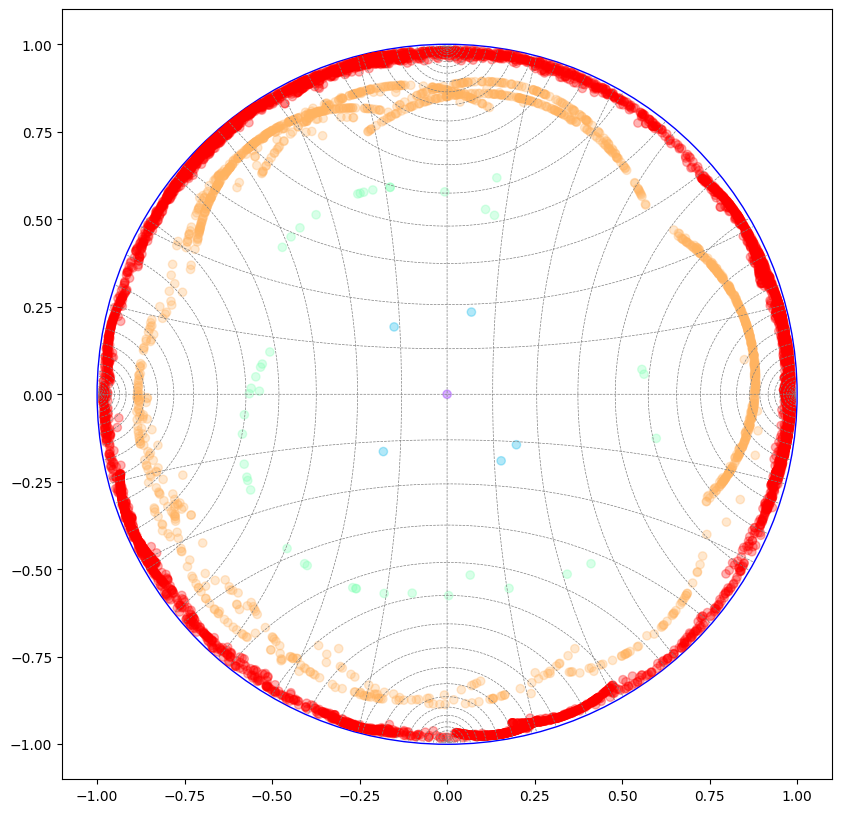

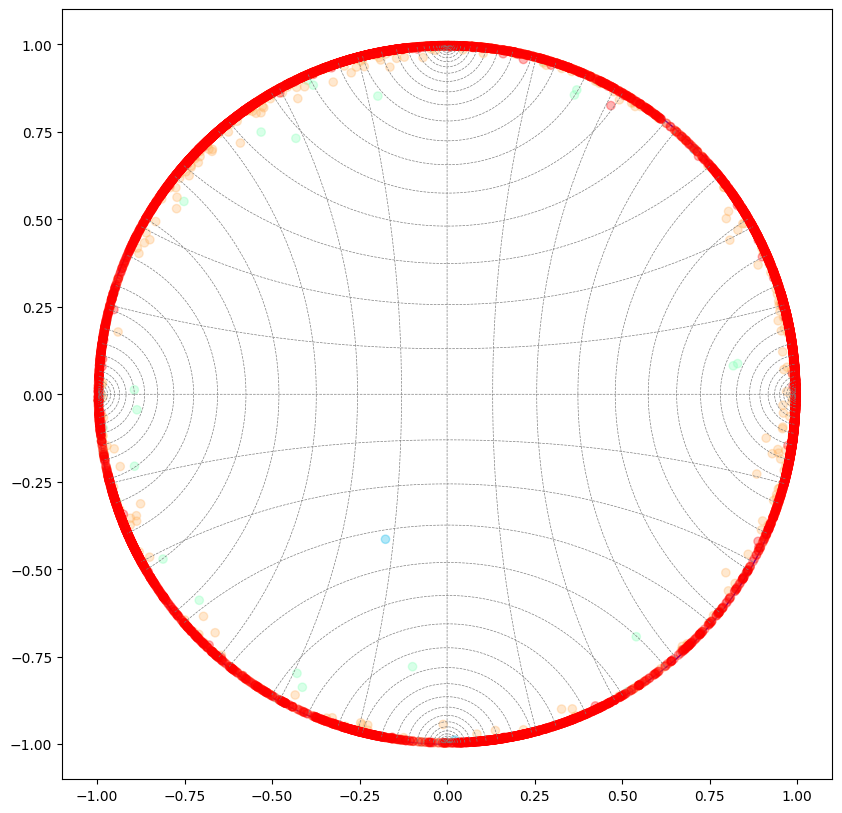

In [10]:
plot(dataset)
train(dataset, ball, lr=1)
print(dataset.embeddings)
plot(dataset)

loss=0.3123388886451721: 100%|██████████| 200/200 [01:51<00:00,  1.80it/s]  


Parameter on PoincareBall manifold containing:
Parameter(ManifoldParameter([[-0.5621, -0.8137],
                   [ 0.9098,  0.3766],
                   [ 0.1085,  0.7802],
                   ...,
                   [ 0.9709,  0.2222],
                   [ 0.1622, -0.9827],
                   [-0.9743, -0.2066]], requires_grad=True))


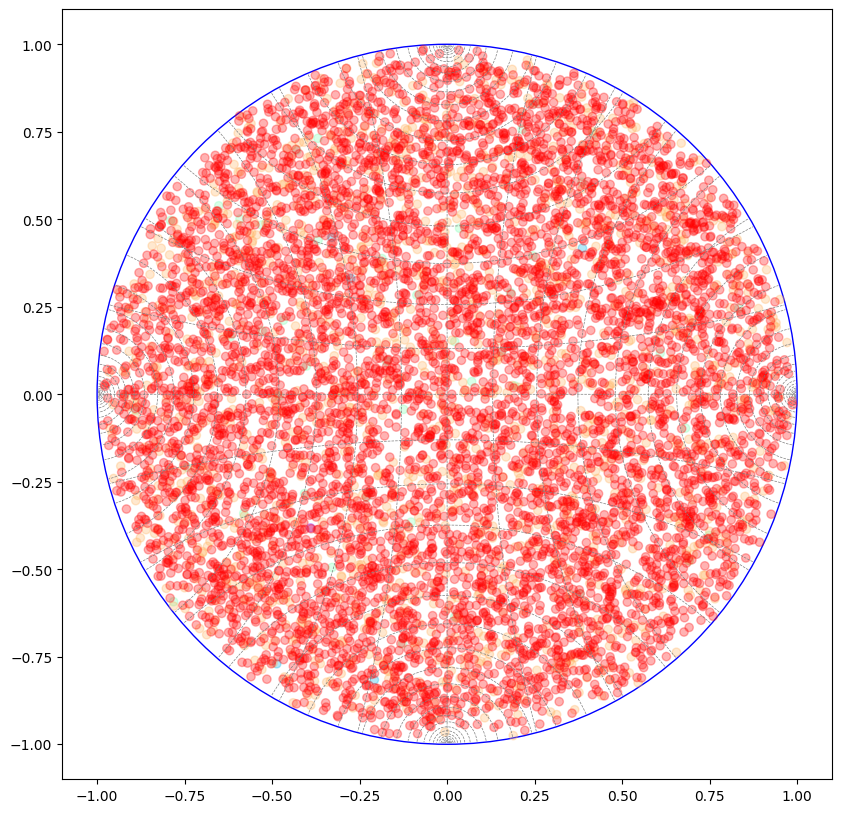

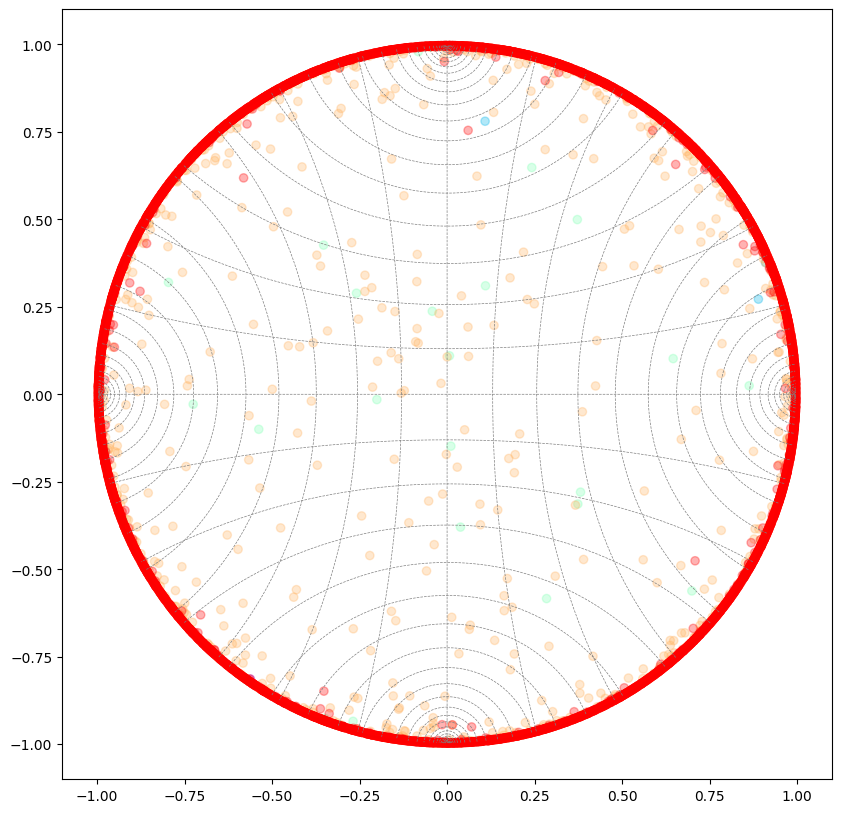

In [7]:
dataset = LabelDataset(ball, embedding_dimension, "../../res/cath/labels.dat")
plot(dataset)
train(dataset, ball, epochs=200, lr=1)
print(dataset.embeddings)
plot(dataset)